In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
import matplotlib.pyplot as plt

import numpy as np
import scipy
import math
import warnings
from utils import *
import statsmodels.formula.api as sm

In [2]:
sigma = 0.5
mu = 5
m = -80

sln = scipy.stats.lognorm(s = sigma, scale = math.exp(mu), loc=m)

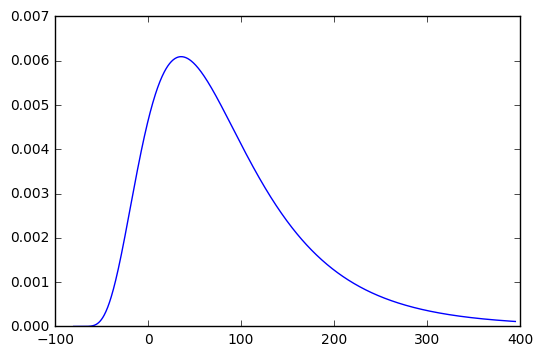

In [3]:
ygrid = np.linspace(sln.ppf(0), sln.ppf(0.99), 1000)
plt.plot(ygrid, sln.pdf(ygrid))

In [4]:
mean = sln.mean()
lorenz = lambda p: integral(sln.ppf)(p)/mean

In this case, the usual formula for the Gini coefficient of a lognormal is incorrect and underestimates the empirical measure.

In [5]:
pgrid = np.linspace(0, 1, 500)
Lgrid = lorenz(pgrid)
empirical_Gini = np.sum((pgrid - Lgrid)/500)*2
ln_Gini = scipy.stats.norm.cdf(sigma/math.sqrt(2))*2 - 1
print("Empirical Gini for shifted distribution", empirical_Gini)
print("Gini of lognormal distribution ignoring shift", ln_Gini)

Empirical Gini for shifted distribution 0.525974965083
Gini of lognormal distribution ignoring shift 0.276326390168


We can calculate a coarser grid then try to fit a spline to the curve, to see if it reproduces the shifted distribution well.

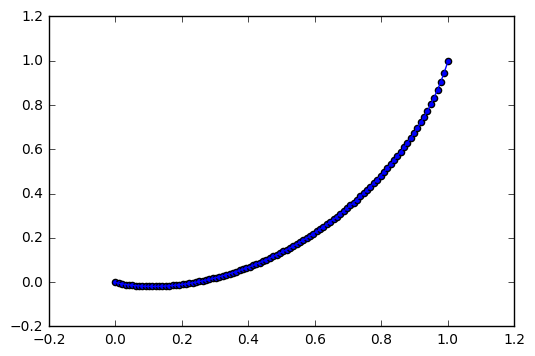

In [6]:
pgrid_coarse = np.linspace(0, 1, 100)
Lgrid_coarse = lorenz(pgrid_coarse)

spline = scipy.interpolate.UnivariateSpline(pgrid_coarse, Lgrid_coarse, k=4, s=0.0001)

plt.plot(pgrid, spline(pgrid))
plt.scatter(pgrid_coarse, Lgrid_coarse)

In [ ]:
quantile = lambda p: derivative(spline)(p) * mean
cdf = inverse(quantile)
pdf = derivative(cdf)

plt.plot(ygrid, sln.pdf(ygrid), c="red")
plt.plot(ygrid, pdf(ygrid))

In [23]:
Lgrid_coarse/(1-Lgrid_coarse**2)**0.5

array([ -0.00000000e+00,  -4.62144706e-03,  -8.04426803e-03,
        -1.08197837e-02,  -1.31004911e-02,  -1.49661249e-02,
        -1.64667792e-02,  -1.76371644e-02,  -1.85028575e-02,
        -1.90835169e-02,  -1.93947199e-02,  -1.94490962e-02,
        -1.92570667e-02,  -1.88273483e-02,  -1.81673107e-02,
        -1.72832365e-02,  -1.61805155e-02,  -1.48637925e-02,
        -1.33370826e-02,  -1.16038613e-02,  -9.66713756e-03,
        -7.52951157e-03,  -5.19322291e-03,  -2.66018972e-03,
         6.79587810e-05,   2.98985507e-03,   6.10437057e-03,
         9.41059644e-03,   1.29078274e-02,   1.65955482e-02,
         2.04734218e-02,   2.45412798e-02,   2.87991143e-02,
         3.32470709e-02,   3.78854435e-02,   4.27146690e-02,
         4.77353245e-02,   5.29481239e-02,   5.83539161e-02,
         6.39536841e-02,   6.97485440e-02,   7.57397452e-02,
         8.19286715e-02,   8.83168418e-02,   9.49059125e-02,
         1.01697680e-01,   1.08694084e-01,   1.15897211e-01,
         1.23309299e-01,

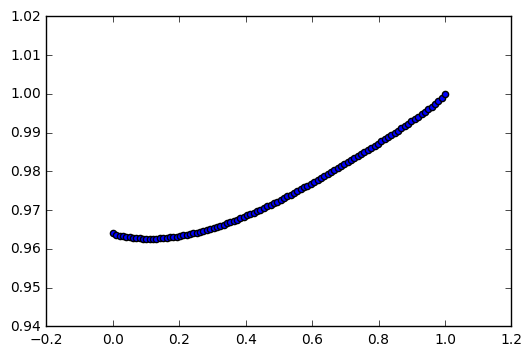

In [63]:
Sig = lambda x: x / (1 + x**2)**0.5
Siginv = lambda y: y / (1 - y**2)**0.5

Sig  = np.tanh
Siginv = np.arctanh
plt.scatter(pgrid_coarse, Sig(Siginv(Lgrid_coarse)+2))

Let's first see what proportion of the population has negative income

## The split curve method

In [ ]:
init_spline = scipy.interpolate.UnivariateSpline(pgrid_coarse, Lgrid_coarse, k = 3, s = 0)

plt.plot(pgrid, init_spline(pgrid))
plt.scatter(pgrid_coarse, Lgrid_coarse)
plt.xlim(0, 0.2)
plt.ylim(-0.1, 0.1)

split_p = scipy.optimize.minimize(init_spline, 0.1, method="TNC", bounds=[(0, 1)]).x
split_L = init_spline(split_p)
print("Splitting curve at spline minimum", split_p)

In [ ]:
right_p = pgrid_coarse[pgrid_coarse > split_p]
right_L = Lgrid_coarse[pgrid_coarse > split_p]
right_p = np.hstack((0, (right_p - split_p) / (1 - split_p)))
right_L = np.hstack((0, (right_L - split_L) / (1 - split_L)))

In [ ]:
right_Gini = gini_from_points(right_p, right_L)
right_sigma = scipy.stats.norm.ppf((right_Gini + 1)/2, 0, 1) * math.sqrt(2)

right_ln_lorenz = lambda p: scipy.stats.norm.cdf(scipy.stats.norm.ppf(p) - right_sigma)
right_ln_invlorenz = lambda L: scipy.stats.norm.cdf(scipy.stats.norm.ppf(L) + right_sigma)

plt.plot(pgrid, right_ln_lorenz(pgrid))
plt.scatter(right_p, right_L)
plt.xlim(0, 0.2)
plt.ylim(-0.1, 0.1)

In [ ]:
right_pstar = right_ln_invlorenz(right_L)
plt.scatter(right_p, right_pstar)

In [ ]:
left_p = pgrid_coarse[pgrid_coarse <= split_p]
left_L = Lgrid_coarse[pgrid_coarse <= split_p]
left_p = -np.hstack(((split_p - left_p), 0))
left_L = -np.hstack(((left_L - split_L), 0))

left_pstar = right_ln_invlorenz(-left_L)

#right_spline = scipy.interpolate.UnivariateSpline(right_p, right_pstar, k=4, s=0)
#left_spline = scipy.interpolate.UnivariateSpline(left_p, left_pstar, k=4, s=0)
both_spline = scipy.interpolate.UnivariateSpline(np.hstack((left_p, right_p[1:])), np.hstack((left_pstar, right_pstar[1:])), k=4, s=0.0001)
left_spline = both_spline
right_spline = both_spline

plt.scatter(left_p, left_pstar)
plt.plot(left_p, left_spline(left_p))
#plt.xlim(-0.2, 0.2)
#plt.ylim(-0.1, 0.1)

In [ ]:
def lorenz_final_scalar(p):
    if p < split_p:
        p = -(split_p - p)
        pstar = left_spline(p)
        return right_ln_lorenz(pstar) + split_L      
    elif p > split_p:
        p = (p - split_p) / (1 - split_p)
        pstar = right_spline(p)
        return (right_ln_lorenz(pstar) + split_L) * (1 - split_L) # (right_L - split_L) / (1 - split_L)
    else:
        return split_L
    
lorenz_final = np.vectorize(lorenz_final_scalar)

In [ ]:
plt.plot(pgrid, lorenz_final(pgrid))
plt.scatter(pgrid_coarse, Lgrid_coarse)
#plt.xlim(0, 0.1)
#plt.ylim(-0.1, 0.1)

In [ ]:
quantile3 = lambda p: derivative(lorenz_final)(p) * mean
cdf3 = inverse(quantile3, domain=(0, 1-1e-2))
pdf3 = derivative(cdf3)

#ygrid2 = np.linspace(-50, 50, 500)
ygrid2 = ygrid

plt.plot(ygrid2, sln.pdf(ygrid2), c="red")
plt.plot(ygrid2, pdf3(ygrid2))
#plt.plot(ygrid, cdf3(ygrid))

In [ ]:
quantile3(0.999)

In [ ]:
C = -0.353553
def lorenz_true_scalar(p): 
    return ((C * sigma * math.exp(0.25 * sigma**2 + mu) *
            math.erf((-2*math.log(sln.ppf(p)-m) + sigma**2 + 2*mu)/(2*sigma))) + 
           (C * m * sigma * math.erf((mu - math.log(sln.ppf(p) - m))/sigma)))

lorenz_true = np.vectorize(lorenz_true_scalar)

In [ ]:
pgrid3 = np.linspace(0.01, 0.99, 100)
plt.plot(pgrid3, (lorenz_true(pgrid3)-lorenz_true(0.00000000001))/mean)

In [ ]:
lorenz_true(1)

In [7]:
import distributions

In [8]:
distributions.normalize_lorenz(pgrid_coarse, Lgrid_coarse)

/Users/andrew/Documents/Ideas/povcaljson/notebooks/distributions.py:21: UserWarning: Lorenz curve appears to have zero or negative incomes. Creating atom of [ 0.10823735] with 0.5555555555555556 points.
  warnings.warn("Lorenz curve appears to have zero or negative incomes. Creating atom of {} with {} points.".format(low_p, np.sum(p[p <= low_p])))


NameError: name 'L_Right' is not defined